In [18]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121
from transformers import TFViTModel

import tensorflow_hub as hub
import tensorflow as tf
import sklearn
from classification_models.keras import Classifiers

In [3]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [4]:
def create_resnet_model(image_size):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [19]:
def create_resnet18_model(image_size):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    # base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [5]:
def create_vgg16_model(image_size):
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [6]:
def create_densenet_model(image_size):
    base_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [7]:
def create_mobilenetv2_model(image_size):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [8]:
def create_efficientnet_model(image_size):
    base_model = tf.keras.applications.EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None) # eventually switch the exact efficient net model
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [9]:
# Not used

def create_mobilenetv3l_model(image_size):
    base_model = tf.keras.applications.MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model
def create_vgg19_model(image_size):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [21]:
def normalize_image(img, label, preprocess_function):
    img = tf.cast(img, np.float32)
    img = preprocess_function(img)
    return img, label

def create_train_dataset(images_train, labels_train, preprocess_function, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(lambda img, label: normalize_image(img, label, preprocess_function))
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

# General method to create validation dataset
def create_val_dataset(images_val, labels_val, preprocess_function, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(lambda img, label: normalize_image(img, label, preprocess_function))
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [22]:
def evaluate_model(model, images_test, labels_test, preprocess_function, batch_size=16):

    # images_test_2 = tf.cast(images_test, np.float32)
    images_test_2 = []
    
    for sample in images_test:
        images_test_2.append(normalize_image(sample, None, preprocess_function)) 
    
    images_test_2 = np.array([tensor[0].numpy() for tensor in images_test_2])
    
    predictions = model.predict(images_test_2, batch_size=batch_size)
    
    auc_per_class = []
    
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    return auc_per_class, balanced_accuracy, accuracy

In [24]:
BATCH_SIZE = 16
NUMBER_OF_IMAGES = 20000
IMAGE_SIZE = 224
evaluations={}

for model_idx in range(10, 11):
    
    sub_evals = []
    
    for run in range(5):

        tf.keras.backend.clear_session()
        
        model = None
        preprocess_function = None
        
        if model_idx == 0:
            model = create_resnet_model(IMAGE_SIZE)
            preprocess_function = tf.keras.applications.resnet.preprocess_input
        elif model_idx == 1:
            model = create_vgg16_model(IMAGE_SIZE)
            preprocess_function = tf.keras.applications.vgg16.preprocess_input
        elif model_idx == 2:
            model = create_densenet_model(IMAGE_SIZE)
            preprocess_function = tf.keras.applications.densenet.preprocess_input
        elif model_idx == 3:
            model = create_mobilenetv2_model(IMAGE_SIZE)
            preprocess_function = tf.keras.applications.mobilenet_v2.preprocess_input
        elif model_idx == 4:
            model = create_efficientnet_model(IMAGE_SIZE)
            preprocess_function = tf.keras.applications.efficientnet_v2.preprocess_input
        elif model_idx == 10:
            model = create_resnet18_model(IMAGE_SIZE)
            _, preprocess_input = Classifiers.get('resnet18')
            preprocess_function = preprocess_input
                
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        images, labels = prepare_data(df[:NUMBER_OF_IMAGES], IMAGE_SIZE)
        images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2, stratify=labels)
        images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], IMAGE_SIZE)
            
        train_dataset = create_train_dataset(images_train, labels_train, preprocess_function)
        val_dataset = create_val_dataset(images_val, labels_val, preprocess_function)
        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # reduceLR_callback = ReduceLROnPlateau(
        #     monitor='val_loss',
        #     factor=0.1,
        #     patience=3,
        #     min_lr=1e-6
        # )     
                    
        model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=20,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping])#, reduceLR_callback]) #######BIRNE
        
        print(f'MODEL NUMBER: {model_idx}')
        sub_eval = evaluate_model(model, images_test, labels_test, preprocess_function)
        sub_evals.append(sub_eval)
        print(sub_evals)
        
    evaluations[model_idx] = sub_evals
    print(evaluations)

100%|██████████| 4000/4000 [01:31<00:00, 43.75it/s]


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - auc: 0.6344 - loss: 1.0424 - val_auc: 0.6971 - val_loss: 0.8715
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - auc: 0.7043 - loss: 0.8557 - val_auc: 0.7059 - val_loss: 0.8638
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - auc: 0.7219 - loss: 0.8387 - val_auc: 0.7077 - val_loss: 0.9081
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - auc: 0.7411 - loss: 0.8183 - val_auc: 0.7030 - val_loss: 0.8946
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - auc: 0.7578 - loss: 0.8017 - val_auc: 0.7084 - val_loss: 0.9049
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - auc: 0.7747 - loss: 0.7787 - val_auc: 0.7092 - val_loss: 0.8811
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - auc: 0.7881 - loss: 0.7568 - val_auc: 0.7081 - val_loss: 0.9513
MODEL NUMBER: 10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step
[([0.7275212898108239, 0.8045016926760795, 0.6534200869476071, 0.7013520470433504], 0.

100%|██████████| 4000/4000 [01:05<00:00, 61.31it/s]


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 66s 61ms/step - auc: 0.6528 - loss: 1.0109 - val_auc: 0.7189 - val_loss: 0.8734
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 56s 55ms/step - auc: 0.7114 - loss: 0.8622 - val_auc: 0.7233 - val_loss: 0.8769
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - auc: 0.7320 - loss: 0.8378 - val_auc: 0.7261 - val_loss: 0.8599
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - auc: 0.7513 - loss: 0.8164 - val_auc: 0.7296 - val_loss: 0.8477
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.7631 - loss: 0.8012 - val_auc: 0.7310 - val_loss: 0.8555
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.7797 - loss: 0.7777 - val_auc: 0.7269 - val_loss: 0.8939
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - auc: 0.8016 - loss: 0.7505 - val_auc: 0.7196 - val_loss: 0.8877
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.8202 - loss: 0.7193 - val_auc: 0.7202 - val_loss: 0.9107
Epoch 9/20
1000/1000 ━━━

100%|██████████| 4000/4000 [01:12<00:00, 54.97it/s]


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 56s 51ms/step - auc: 0.6453 - loss: 1.0499 - val_auc: 0.7194 - val_loss: 0.8563
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.7128 - loss: 0.8479 - val_auc: 0.7271 - val_loss: 0.8445
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - auc: 0.7250 - loss: 0.8347 - val_auc: 0.7298 - val_loss: 0.8453
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.7369 - loss: 0.8248 - val_auc: 0.7230 - val_loss: 0.8610
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.7537 - loss: 0.8030 - val_auc: 0.7261 - val_loss: 0.8559
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - auc: 0.7727 - loss: 0.7805 - val_auc: 0.7127 - val_loss: 0.8793
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - auc: 0.7890 - loss: 0.7591 - val_auc: 0.7045 - val_loss: 0.8784
MODEL NUMBER: 10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step
[([0.7275212898108239, 0.8045016926760795, 0.6534200869476071, 0.7013520470433504], 0.

100%|██████████| 4000/4000 [01:04<00:00, 61.96it/s]


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 50ms/step - auc: 0.6465 - loss: 0.9905 - val_auc: 0.7241 - val_loss: 0.8520
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - auc: 0.7120 - loss: 0.8498 - val_auc: 0.7344 - val_loss: 0.8393
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.7294 - loss: 0.8337 - val_auc: 0.7306 - val_loss: 0.8446
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - auc: 0.7415 - loss: 0.8205 - val_auc: 0.7368 - val_loss: 0.8511
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.7584 - loss: 0.8011 - val_auc: 0.7277 - val_loss: 0.8431
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.7756 - loss: 0.7796 - val_auc: 0.7214 - val_loss: 0.8630
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - auc: 0.7916 - loss: 0.7581 - val_auc: 0.7203 - val_loss: 0.8909
MODEL NUMBER: 10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step
[([0.7275212898108239, 0.8045016926760795, 0.6534200869476071, 0.7013520470433504], 0.

100%|██████████| 4000/4000 [00:58<00:00, 67.94it/s]


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 49ms/step - auc: 0.6423 - loss: 1.0371 - val_auc: 0.7151 - val_loss: 0.8729
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - auc: 0.7045 - loss: 0.8551 - val_auc: 0.7187 - val_loss: 0.9032
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.7214 - loss: 0.8360 - val_auc: 0.7218 - val_loss: 0.8584
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - auc: 0.7327 - loss: 0.8230 - val_auc: 0.7168 - val_loss: 0.8667
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.7490 - loss: 0.8067 - val_auc: 0.7129 - val_loss: 0.8520
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.7689 - loss: 0.7814 - val_auc: 0.7048 - val_loss: 0.8990
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - auc: 0.7855 - loss: 0.7615 - val_auc: 0.6893 - val_loss: 0.9513
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.8074 - loss: 0.7279 - val_auc: 0.6814 - val_loss: 0.9351
Epoch 9/20
1000/1000 ━━━

In [25]:
# fixed preprocessing:

evaluations_resnet = [([0.7110724102072454, 0.8271946906573061, 0.6728702127223123, 0.7296664482365302], 0.3008836232356599, 0.691),
                      ([0.7146155112547893, 0.80065312525803, 0.6578247698162604, 0.7007470927711972], 0.27240775432148917, 0.679),
                      ([0.699984183829095, 0.8066815281056037, 0.6669614918783956, 0.7122905391246541], 0.29812093743125706, 0.6895),
                      ([0.7243810508911535, 0.8102090463035501, 0.6669452359051443, 0.7180336873155648], 0.26842440397708495, 0.697),
                      ([0.7450829271496119, 0.8153315523360901, 0.6711799824474232, 0.7189197859582614], 0.31752588711967, 0.699)]

evaluations_resnet18 = [([0.7275212898108239, 0.8045016926760795, 0.6534200869476071, 0.7013520470433504], 0.2638821745705661, 0.681), 
                        ([0.7005396326882594, 0.7968012938193898, 0.6648057227503198, 0.7043007131966674], 0.32669983854443835, 0.678), 
                        ([0.7234005665455999, 0.7916357426572657, 0.6558333146374113, 0.7141485666836425], 0.2622229798324623, 0.69425), 
                        ([0.7331290861595938, 0.7995583218996997, 0.6673386904863892, 0.7226263395203063], 0.2778641185210826, 0.699), 
                        ([0.7174546535831102, 0.7805091140462784, 0.6899517748363848, 0.7197585868680139], 0.29469913789996305, 0.687)]

evaluations_vgg16 = [([0.7132395525972688, 0.8065531287668779, 0.6760710227716016, 0.7062028092382857], 0.30027347516196756, 0.691),
                     ([0.7180228276035591, 0.8199251625162263, 0.6707835464783355, 0.7118447304455341], 0.3127939853231483, 0.686),
                     ([0.7242822790504098, 0.8155249272197961, 0.6552404502849607, 0.7156922986201204], 0.27557846579878953, 0.6955),
                     ([0.7102374715428171, 0.8290136332917446, 0.6282501832205416, 0.7077895070808458], 0.3311702781530368, 0.68175),
                     ([0.726256090823346, 0.8074809000523286, 0.6601570154136112, 0.720794839629154], 0.2582406067792974, 0.7)]

evaluations_dense = [([0.7191733228760329, 0.8118156334682104, 0.6550751583214378, 0.7119819956969501], 0.3096633695875244, 0.706),
                     ([0.7051452242411208, 0.8149404954411962, 0.6531037003509264, 0.7009477765198198], 0.2975190949819138, 0.681),
                     ([0.7335757488479262, 0.810540203400347, 0.6626943267888206, 0.7217394621523567], 0.28897090525447444, 0.69425),
                     ([0.7306096750626857, 0.8190892642830467, 0.670117087581511, 0.725941228974911], 0.30410861590287486, 0.69725),
                     ([0.7403070219705381, 0.8079386616700049, 0.6741107627015099, 0.7199755260990657], 0.3110785409921934, 0.698)]

evaluations_mobilev2 = [([0.6970239875256323, 0.7874397078804347, 0.645648363422639, 0.6955619934754269], 0.30298760998272245, 0.685),
                        ([0.6995763377377564, 0.7922884558219885, 0.6555770916645651, 0.703124778044519], 0.2982323389431243, 0.69675),
                        ([0.7189856926924876, 0.8125231573003073, 0.6661796325892, 0.7238118280640309], 0.2958039478815519, 0.68425),
                        ([0.7106372350933908, 0.7965411609280819, 0.6480949824936353, 0.6954959523293744], 0.27702347137556455, 0.67675),
                        ([0.7127736291710443, 0.8050476440248272, 0.6658396303421363, 0.7120789646725583], 0.31597703769719054, 0.6895)]

evaluations_efficient = [([0.7369762783842159, 0.8117709978538178, 0.6694894522720307, 0.7206270292207791], 0.29274429648614453, 0.69625),
                         ([0.7136595073080354, 0.7956909313560921, 0.6800343850759691, 0.721434697470205], 0.2791733120680489, 0.687),
                         ([0.7188700564971751, 0.7859900301365247, 0.6556229719412101, 0.7084597857801882], 0.26364176868973455, 0.69325),
                         ([0.7142579381261273, 0.8238109859118321, 0.6469097075031793, 0.7150928765184574], 0.2713218710745689, 0.6935),
                         ([0.7199220346156092, 0.8265418681118736, 0.6330325657029795, 0.7118689971445875], 0.2999323990703301, 0.68625)]


In [ ]:
# 10,000 samples size224
# mobile and dense net have best val loss after 3 epochs, after that only overfitting


evaluations_mobilev2 = [([0.705199367971001, 0.803903842636237, 0.6460981394492032, 0.7011392571234616], 0.282599714875317, 0.7005),
                      ([0.69857910906298, 0.7825738028322127, 0.686005665937538, 0.718622030585018], 0.27490938833173095, 0.6935),
                      ([0.703420965286759, 0.7771263259402121, 0.6214206039048666, 0.6921624829017055], 0.25222499170745993, 0.6925),
                      ([0.7258387949771093, 0.8135429642694162, 0.6394139616113841, 0.7238595847802269], 0.33982969835560545, 0.6835),
                      ([0.665603367536314, 0.8241186315732858, 0.6309255165638143, 0.714961401958212], 0.2667250064888405, 0.6855)]

evaluations_dense = [([0.7656006003729589, 0.7968915362947189, 0.6445603193731332, 0.734302791443053], 0.2726910672656741, 0.6865),
                     ([0.6881294852036925, 0.8185377809660449, 0.6628734464916098, 0.7216383163168159], 0.2906261544197827, 0.703),
                     ([0.6887140484308069, 0.8160272628698301, 0.6163321029286669, 0.6940791876689312], 0.26448743829481186, 0.674),
                     ([0.7171291196782935, 0.8082851667026081, 0.6470281823152245, 0.7245076918268336], 0.2686624541341933, 0.6835),
                     ([0.7274079761961896, 0.8017894867652542, 0.655972644612711, 0.7097759810004136], 0.2925578221248356, 0.7125)]

evaluations_resnet = [([0.6104132870419503, 0.6840325244930507, 0.5990613088404133, 0.6504207224986226], 0.249909207374812, 0.687),
                      ([0.5720783753185208, 0.6570918918918919, 0.5841528182916409, 0.6229793683938951], 0.2507716049382716, 0.682),
                      ([0.5799318486953476, 0.6543798661645717, 0.6071499222834534, 0.6327051426264024], 0.24981684981684982, 0.682),
                      ([0.599961607423654, 0.7006001776552879, 0.5964987370838117, 0.6351107626644916], 0.2511769286389677, 0.6915),
                      ([0.6405453149001537, 0.6690173906288525, 0.5880346629009731, 0.6407573286531504], 0.2510955806108038, 0.696)]

In [27]:
# 20,000 samples size224 

# 100 seconds
evaluations_resnet_old = [([0.6059535362545011, 0.6815362382316886, 0.6190353560004435, 0.6531992828088194], 0, 0),
                      ([0.6100367921465821, 0.6914004009778256, 0.6168105099967441, 0.6531414848733504], 0, 0),
                      ([0.6109117641386872, 0.6871840742526674, 0.613840154627441, 0.6522705421909071], 0, 0),
                      ([0.6081676546645143, 0.6892624542718719, 0.6161844289734153, 0.6520885762780548], 0, 0),
                      ([0.6318296392872664, 0.6913406815985992, 0.6139735636571866, 0.6571628286007334], 0.25161911310428337, 0.68925)]

# 60 seconds
evaluations_mobilev2_old = [([0.704838815597455, 0.8055553700184683, 0.6633923458675319, 0.7225655361828393], 0.33158208642409237, 0.68925), 
                      ([0.68300573083279, 0.7959628880474598, 0.650131888043487, 0.7138845101870103], 0.283828966567713, 0.684),
                      ([0.7182393733064247, 0.7849467540757703, 0.6398127450980393, 0.7039394088398717], 0.25964803219435606, 0.696),
                      ([0.6976476847989594, 0.8176590178675092, 0.6575790844581847, 0.704623688745686], 0.3004115179927809, 0.6925)]

# 140 seconds
evaluations_dense_old = [([0.7294378360825581, 0.8240495700218503, 0.6581664146024442, 0.7323697015182481], 0.2833722334573324, 0.6855), 
                     ([0.6986836985153257, 0.8038312278094294, 0.6244299407411453, 0.693680660264377], 0.26462333636233537, 0.6815), 
                     ([0.7054821860960795, 0.8024486406154384, 0.6618956139252634, 0.7126230751999769], 0.2895685709766684, 0.6855), 
                     ([0.7218725389940877, 0.8034263802416195, 0.6596673808508888, 0.7168842937978033], 0.27455063271049823, 0.69875)]

# 150 seconds
evaluations_vgg16_old = [([0.7221943025912425, 0.8067758746177346, 0.6753560445995164, 0.7290617978387248], 0.2860127302842016, 0.68575),
                     ([0.7280236021312261, 0.8140194864173066, 0.6612781414646791, 0.71468822677143], 0.2917244532098595, 0.68525),
                     ([0.7080099491246502, 0.7972112946935921, 0.6622106326446451, 0.70988951593673], 0.3201316927078488, 0.68525),
                     ([0.7325089820593893, 0.8158939100317487, 0.6841038857604381, 0.7265547539433401], 0.30038263070185467, 0.69725),
                     ([0.7449798610705738, 0.8087063808315852, 0.6809395578349792, 0.7336545093273779], 0.30525345793578085, 0.698)]

# 180 seconds for efficient

evaluations_vgg19 = [([0.7141272300047893, 0.8027503922054329, 0.6592474837258631, 0.7073429257980947], 0.28817968433954044, 0.6805),
                     ([0.6932274779609191, 0.7947180697613428, 0.6516135285731401, 0.6983355854065654], 0.2949090586842209, 0.68375),
                     ([0.7301689449949262, 0.8067335312469935, 0.6673212576372842, 0.7131742726388476], 0.29947513667548936, 0.69375),
                     ([0.736232925690269, 0.8081076270688542, 0.6694323397661053, 0.721764947029127], 0.3062035153820486, 0.69025),
                     ([0.7223733388229374, 0.797132936222459, 0.6789260432432994, 0.7154018270227256], 0.2840161483253589, 0.688)]

evaluations_mobilev3 = [([0.6341929138360896, 0.7251110279800101, 0.6184788575757103, 0.6696227399326375], 0.25012460127591707, 0.6835),
                        ([0.6624204579244721, 0.6971046412280189, 0.6148084080931475, 0.665095963356891], 0.25179996672552235, 0.6875),
                        ([0.6530976874019951, 0.7405434471823664, 0.6120371155385992, 0.6690532492039156], 0.25234027064063036, 0.69275),
                        ([0.6352295363668203, 0.7427325392493241, 0.6042538867930158, 0.6798951573361022], 0.2530272888031509, 0.682),
                        ([0.6362670693130356, 0.6845948717948718, 0.6208518998845884, 0.6648166925229552], 0.25022629550917214, 0.6985)]

In [25]:
# mobile v2, reduce lr
# [([0.7348789426277355, 0.8164745597879742, 0.654450254457434, 0.7307610515694221], 0.31482315252739806, 0.6935), ([0.7155967507782566, 0.8021179093386178, 0.6378526063017542, 0.7005642328942312], 0.29607361663664233, 0.678)]

# [([0.7319606999007648, 0.7981171656569357, 0.6517869551228965, 0.7119072446700697], 0.31093656800914715, 0.69925)]

# [([0.7197227749948536, 0.790278917388326, 0.6665706718839474, 0.7126789653379793], 0.29696704363781656, 0.69175), ([0.7233227253427278, 0.8270580714545643, 0.6584145824501908, 0.7215641585092581], 0.3047127371218885, 0.69575), ([0.7013847338158894, 0.8320986691619878, 0.6467647821214049, 0.7220276311614895], 0.2956641787460753, 0.6845), ([0.7314960557817163, 0.7880590266875981, 0.6601004833491512, 0.7207669296832667], 0.30387955200585465, 0.702)]

# all above mobile v2

evaluations_mobilev2 = [([0.7331982882259481, 0.8106255209178874, 0.6615986528394988, 0.726898848956859], 0.30700383055240754, 0.69075),
                        ([0.7308634907806515, 0.810777805300966, 0.6560201883909589, 0.7082947128885307], 0.294041146803279, 0.679),
                        ([0.7040987418612621, 0.8001355013550135, 0.6550208464310668, 0.7133208084340745], 0.30542740088067877, 0.68675),
                        ([0.7149542963041323, 0.8167494742918401, 0.6573247818185898, 0.7207741190335333], 0.29996690888359234, 0.69725),
                        ([0.7290073550872687, 0.8001864517489139, 0.6544236491464536, 0.7149587000788229], 0.31224306977475036, 0.6945)]

evaluations_dense = [([0.7314073972414739, 0.8001528333317346, 0.6672941281052129, 0.7189171339477386], 0.3070675533208985, 0.68625),
                     ([0.727679041149157, 0.8086715965583903, 0.6612922313418592, 0.720849491145987], 0.2976571690096504, 0.6935),
                     ([0.7244168057476532, 0.8282565892077355, 0.6522250482784607, 0.7242183630145065], 0.2913113154021215, 0.69675),
                     ([0.7119467266942969, 0.8282679611145768, 0.6561216174131311, 0.7280277465316836], 0.29171234753131303, 0.687),
                     ([0.7412871592369391, 0.7971231815803245, 0.6710394378221548, 0.7316025208025594], 0.29120762558810137, 0.69825)]

evaluations_vgg16 = [([0.7338690036686394, 0.8134529447541579, 0.6774651787728979, 0.7322329302042134], 0.31454198580586734, 0.69225),
                     ([0.7383542115660919, 0.8200115597390802, 0.6691227657057006, 0.7134216574201762], 0.3139052467366153, 0.684),
                     ([0.7110950438898743, 0.8136786432380453, 0.6711231494333029, 0.7182039294462791], 0.31381967053986043, 0.68925),
                     ([0.7286497329869804, 0.8174048914910871, 0.6800445336863123, 0.727043297644993], 0.2921919870254499, 0.69825),
                     ([0.7528967952834044, 0.818092040462967, 0.6775980003007926, 0.7332703649313116], 0.3158910008469848, 0.69425)]

0.00970305965943214
0.009113719848745743
0.008306787845674783
0.009160546531863864
0.011437169734650062

[0.72853226 0.72342936 0.72616812 0.72944111 0.71721251 0.72550315]

{'at': 0.7190272166663789, 'ef': 0.812013988532116, 'in': 0.6671563385539072, 'nf': 0.7159315106812416}
{'at': 0.7184076443234801, 'ef': 0.8156995503693947, 'in': 0.65810044363381, 'nf': 0.712464837002788}
{'at': 0.7257621985996607, 'ef': 0.8128648516525612, 'in': 0.663020207148841, 'nf': 0.7161171978886205}
{'at': 0.7077993764440622, 'ef': 0.798768025191128, 'in': 0.6562679401024352, 'nf': 0.7060147033171819}
{'at': 0.7207371629862326, 'ef': 0.808760962674028, 'in': 0.6570178164990738, 'nf': 0.7154966772268434}


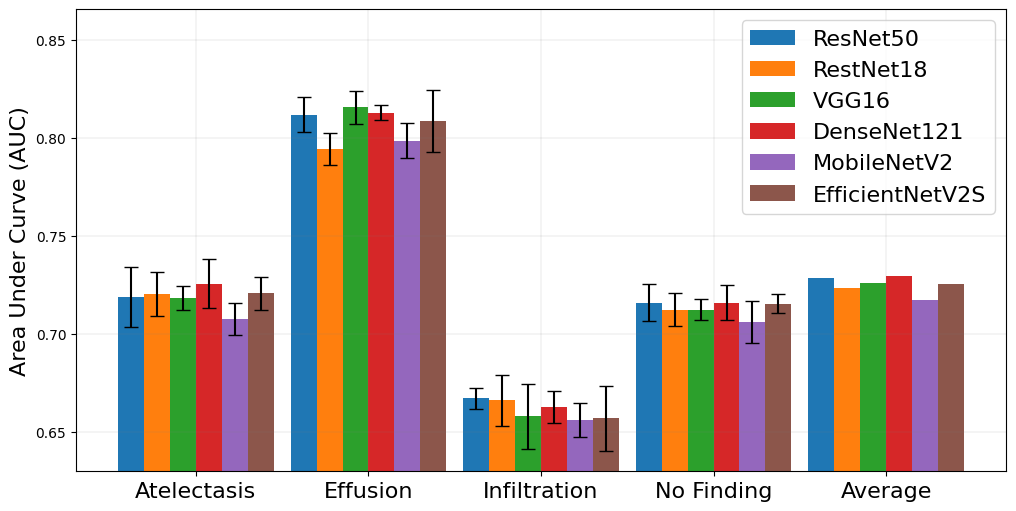

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

resnet50_at, resnet50_ef, resnet50_in, resnet50_nf = [], [], [], []
for eval in evaluations_resnet:
    resnet50_at.append(eval[0][0])
    resnet50_ef.append(eval[0][1])
    resnet50_in.append(eval[0][2])
    resnet50_nf.append(eval[0][3])
resnet50_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [resnet50_at, resnet50_ef, resnet50_in, resnet50_nf])}
resnet50_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [resnet50_at, resnet50_ef, resnet50_in, resnet50_nf])}

resnet18_at, resnet18_ef, resnet18_in, resnet18_nf = [], [], [], []
for eval in evaluations_resnet18:
    resnet18_at.append(eval[0][0])
    resnet18_ef.append(eval[0][1])
    resnet18_in.append(eval[0][2])
    resnet18_nf.append(eval[0][3])
resnet18_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [resnet18_at, resnet18_ef, resnet18_in, resnet18_nf])}
resnet18_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [resnet18_at, resnet18_ef, resnet18_in, resnet18_nf])}

vgg16_at, vgg16_ef, vgg16_in, vgg16_nf = [], [], [], []
for eval in evaluations_vgg16:
    vgg16_at.append(eval[0][0])
    vgg16_ef.append(eval[0][1])
    vgg16_in.append(eval[0][2])
    vgg16_nf.append(eval[0][3])
vgg16_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [vgg16_at, vgg16_ef, vgg16_in, vgg16_nf])}
vgg16_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [vgg16_at, vgg16_ef, vgg16_in, vgg16_nf])}

dense_at, dense_ef, dense_in, dense_nf = [], [], [], []
for eval in evaluations_dense:
    dense_at.append(eval[0][0])
    dense_ef.append(eval[0][1])
    dense_in.append(eval[0][2])
    dense_nf.append(eval[0][3])
dense_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [dense_at, dense_ef, dense_in, dense_nf])}
dense_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [dense_at, dense_ef, dense_in, dense_nf])}

mobile_at, mobile_ef, mobile_in, mobile_nf = [], [], [], []
for eval in evaluations_mobilev2:
    mobile_at.append(eval[0][0])
    mobile_ef.append(eval[0][1])
    mobile_in.append(eval[0][2])
    mobile_nf.append(eval[0][3])
mobile_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [mobile_at, mobile_ef, mobile_in, mobile_nf])}
mobile_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [mobile_at, mobile_ef, mobile_in, mobile_nf])}

efficient_at, efficient_ef, efficient_in, efficient_nf = [], [], [], []
for eval in evaluations_efficient:
    efficient_at.append(eval[0][0])
    efficient_ef.append(eval[0][1])
    efficient_in.append(eval[0][2])
    efficient_nf.append(eval[0][3])
efficient_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [efficient_at, efficient_ef, efficient_in, efficient_nf])}
efficient_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [efficient_at, efficient_ef, efficient_in, efficient_nf])}

performance = np.array([[resnet50_means['at'], resnet50_means['ef'], resnet50_means['in'], resnet50_means['nf']],
                        [resnet18_means['at'], resnet18_means['ef'], resnet18_means['in'], resnet18_means['nf']],
                        [vgg16_means['at'], vgg16_means['ef'], vgg16_means['in'], vgg16_means['nf']],
                        [dense_means['at'], dense_means['ef'], dense_means['in'], dense_means['nf']],
                        [mobile_means['at'], mobile_means['ef'], mobile_means['in'], mobile_means['nf']],
                        [efficient_means['at'], efficient_means['ef'], efficient_means['in'], efficient_means['nf']]])
row_averages = np.mean(performance, axis=1)
performance = np.column_stack((performance, row_averages))

std_dev = np.array([[resnet50_stds['at'], resnet50_stds['ef'], resnet50_stds['in'], resnet50_stds['nf'], np.NaN],
                    [resnet18_stds['at'], resnet18_stds['ef'], resnet18_stds['in'], resnet18_stds['nf'], np.NaN],
                    [vgg16_stds['at'], vgg16_stds['ef'], vgg16_stds['in'], vgg16_stds['nf'], np.NaN],
                    [dense_stds['at'], dense_stds['ef'], dense_stds['in'], dense_stds['nf'], np.NaN],
                    [mobile_stds['at'], mobile_stds['ef'], mobile_stds['in'], mobile_stds['nf'], np.NaN],
                    [efficient_stds['at'], efficient_stds['ef'], efficient_stds['in'], efficient_stds['nf'], np.NaN]])

print(np.mean(list(resnet50_stds.values())))
print(np.mean(list(vgg16_stds.values())))
print(np.mean(list(dense_stds.values())))
print(np.mean(list(mobile_stds.values())))
print(np.mean(list(efficient_stds.values())))

print()
print(row_averages)
print()

print(resnet50_means)
print(vgg16_means)
print(dense_means)
print(mobile_means)
print(efficient_means)


labels = ['Atelectasis', 'Effusion', 'Infiltration', 'No Finding', 'Average']
model_names = ['ResNet50', 'RestNet18', 'VGG16', 'DenseNet121', 'MobileNetV2', "EfficientNetV2S"]
n_models = len(model_names)
n_labels = len(labels)

font_size = 16

x = np.arange(n_labels)  # positions of the labels
width = 0.15  # width of each bar, smaller to fit all models in each label group

# Create a plot
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(n_models):
    ax.bar(x + i * width, performance[i], width, yerr=std_dev[i], label=model_names[i], capsize=5)

ax.set_xticks(x + width * (n_models - 1) / 2)  # Place the x-ticks in the middle of the grouped bars
ax.set_xticklabels(labels, fontsize=font_size)
ax.legend(fontsize=font_size, loc="upper right")
ax.set_ylim(0.63)
ax.set_ylabel("Area Under Curve (AUC)", fontsize=font_size)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

plt.savefig("evals/models/models_20000samples_20epochs_5runs_ES.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

In [ ]:
        shuffled_indices = np.random.permutation(len(images_all))
        shuffled_images = images_all[shuffled_indices][:NUMBER_OF_IMAGES]
        shuffled_labels = labels_all[shuffled_indices][:NUMBER_OF_IMAGES]
        
        images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(shuffled_images, shuffled_labels, random_state=42, test_size=0.2, stratify=shuffled_labels)
        images_test = shuffled_images[-(int(NUMBER_OF_IMAGES / 5)):]
        labels_test = shuffled_labels[-(int(NUMBER_OF_IMAGES / 5)):]
        
        print(images_train.shape)
        print(labels_train.shape)
        print(images_val.shape)
        print(labels_val.shape)
        print(images_test.shape)
        print(labels_test.shape)